In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [2]:
df = pd.read_csv("../datasets/perceptron_toydata-truncated.txt", sep="\t")
df

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0
5,0.39,-1.99,0
6,-0.49,-2.74,0
7,-0.68,-1.52,0
8,-0.10,-3.43,0
9,-0.05,-1.95,0


In [3]:
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

print("Train set:", X_train.shape, y_train.shape)

Train set: (20, 2) (20,)


### Data Preprocessing

In [4]:
# scaling for better convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [5]:
print("Training labels:")
counts = Counter(y_train)
for key, value in counts.items():
    print(f"{key}: {value}")

Training labels:
0: 10
1: 10


### Visualize the Dataset

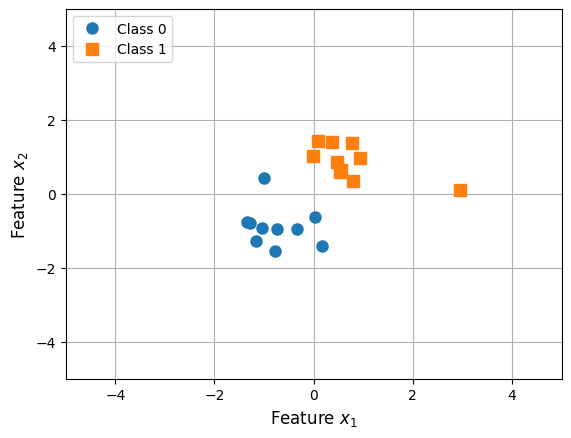

In [6]:
from modules.plotting_helper import plot_feature2d
plot_feature2d(X_train, y_train, markersize=8)

### Define the DataLoader

In [7]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]

train_ds = MyDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_ds, batch_size=10, shuffle=True)

### Design the Model

In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()        
        self.linear = torch.nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits
    
    def predict(self, x):
        self = self.eval()           # set dropout/batchnorm to eval mode
        with torch.inference_mode(): # disables gradient computation
            return torch.sigmoid(self(x))
        
model = LogisticRegression(2)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.00)

In [9]:
model

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

### Train the model

In [10]:
def train(model, num_epochs):
    history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model = model.train()        
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            # forward pass
            logits = model(x_batch)
            loss = criterion(logits, y_batch.view(logits.shape))
            #loss = F.binary_cross_entropy(y_pred, y_batch.view(y_pred.shape))
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()        
            optimizer.step()
            
            epoch_loss += abs(loss)
            history.append(loss)
            print(f' -> batch: {batch_idx+1:03d} | loss: {loss:.2f}')
            
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | epoch_loss: {epoch_loss:.2f}')
    return history

history = train(model, num_epochs=20)

 -> batch: 001 | loss: 0.83
 -> batch: 002 | loss: 0.47
Epoch: 001/020 | epoch_loss: 1.30
 -> batch: 001 | loss: 0.33
 -> batch: 002 | loss: 0.25
Epoch: 002/020 | epoch_loss: 0.58
 -> batch: 001 | loss: 0.22
 -> batch: 002 | loss: 0.16
Epoch: 003/020 | epoch_loss: 0.39
 -> batch: 001 | loss: 0.15
 -> batch: 002 | loss: 0.15
Epoch: 004/020 | epoch_loss: 0.30
 -> batch: 001 | loss: 0.14
 -> batch: 002 | loss: 0.11
Epoch: 005/020 | epoch_loss: 0.25
 -> batch: 001 | loss: 0.12
 -> batch: 002 | loss: 0.09
Epoch: 006/020 | epoch_loss: 0.22
 -> batch: 001 | loss: 0.07
 -> batch: 002 | loss: 0.12
Epoch: 007/020 | epoch_loss: 0.19
 -> batch: 001 | loss: 0.08
 -> batch: 002 | loss: 0.09
Epoch: 008/020 | epoch_loss: 0.17
 -> batch: 001 | loss: 0.08
 -> batch: 002 | loss: 0.08
Epoch: 009/020 | epoch_loss: 0.16
 -> batch: 001 | loss: 0.06
 -> batch: 002 | loss: 0.09
Epoch: 010/020 | epoch_loss: 0.15
 -> batch: 001 | loss: 0.05
 -> batch: 002 | loss: 0.08
Epoch: 011/020 | epoch_loss: 0.14
 -> batch:

In [11]:
bias = model.linear.bias.data.numpy()
weights = model.linear.weight.data.numpy().flatten()
print("Bias:", bias)
print("Weights:", weights)

Bias: [-0.20638697]
Weights: [2.2527082 2.718755 ]


### Evaluate the Model

In [12]:
predictions = model.predict(train_ds.features)
y_preds = (predictions >= 0.5).float()

train_acc = accuracy_score(train_ds.labels, y_preds)
print(f"Train Accuracy: {train_acc:.2f}")

cmat = confusion_matrix(train_ds.labels, y_preds)
print("Confusion Matrix:")
print(cmat)

Train Accuracy: 1.00
Confusion Matrix:
[[10  0]
 [ 0 10]]


### Vizualize the Results

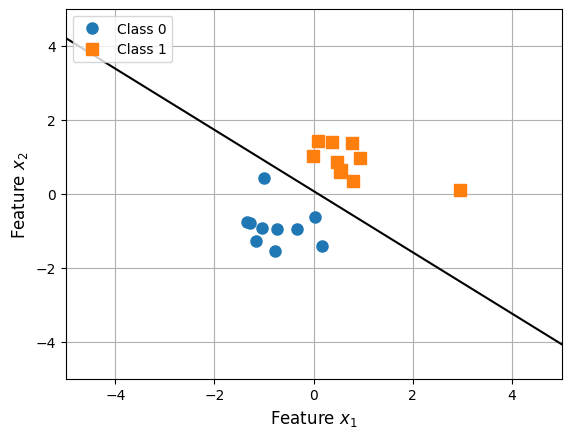

In [13]:
plot_feature2d(X_train, y_train, bias, weights, markersize=8)